### SST timeseris for NAO extremes

In this notebook, we look at area-integrated surface properties to see if ANO extremes have any long-term impact.

In [1]:
import numpy as np
import math
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as mtick
import dask
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler, ProgressBar, visualize

In [2]:
ppdir = "/home/users/hkhatri/DePreSys4_Data/Data_Anomaly_Compute/NAO/"

ds_NAO = xr.open_dataset(ppdir + "NAO_SLP_Anomaly.nc")

ppdir = "/home/users/hkhatri/DePreSys4_Data/Data_Anomaly_Compute/"

ds_anom = []

var_list2 = ['hfds', 'tos', 'sos']

for var in var_list2:
    
    ds = []
    
    for i in range(0,10):
    
        d = xr.open_dataset(ppdir + "Area_mean_timeseries/Anomaly_" + var + "_r" + str(i+1) + ".nc")
        
        ds.append(d)
    
    ds = xr.concat(ds, dim='r')
    
    ds_anom.append(ds)

ds_anom = xr.concat(ds_anom, dim='var')

print(ds_anom, ds_NAO)

<xarray.Dataset>
Dimensions:            (var: 3, r: 10, start_year: 57, time: 125)
Dimensions without coordinates: var, r, start_year, time
Data variables:
    Labrador_Sea       (var, r, start_year, time) float32 -23.22 ... -0.225
    Irminger_Sea       (var, r, start_year, time) float32 -26.75 ... -0.1122
    Iceland_Basin      (var, r, start_year, time) float32 13.48 ... -0.09676
    North_East_Region  (var, r, start_year, time) float32 7.781 ... -0.2074
    South_West_Region  (var, r, start_year, time) float32 4.255 ... -0.2022
    South_East_Region  (var, r, start_year, time) float32 18.08 ... -0.1562
    North_Atlantic     (var, r, start_year, time) float32 0.5261 ... 0.02443 <xarray.Dataset>
Dimensions:     (start_year: 57, r: 10, time: 125)
Coordinates:
  * start_year  (start_year) int64 1960 1961 1962 1963 ... 2013 2014 2015 2016
Dimensions without coordinates: r, time
Data variables:
    NAO         (start_year, r, time) float64 ...
    P_south     (start_year, r, time) float

In [3]:
ds_mask = xr.open_dataset('/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/Mask_Regions.nc')
ds_area = xr.open_dataset('/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/Area.nc')
ds_mask['area'] = ds_area['area_t'].rename({'x':'i', 'y':'j'})

print(ds_mask, ds_area)

<xarray.Dataset>
Dimensions:         (j: 450, i: 450)
Coordinates:
  * j               (j) int64 699 700 701 702 703 ... 1144 1145 1146 1147 1148
  * i               (i) int64 749 750 751 752 753 ... 1194 1195 1196 1197 1198
    nav_lat         (j, i) float32 ...
    nav_lon         (j, i) float32 ...
Data variables:
    mask_regions    (j, i) float64 ...
    mask_North_Atl  (j, i) float64 ...
    area            (j, i) float32 ... <xarray.Dataset>
Dimensions:    (yv: 450, xu: 450, y: 450, x: 450)
Coordinates:
  * yv         (yv) float64 700.5 701.5 702.5 ... 1.148e+03 1.148e+03 1.15e+03
  * xu         (xu) float64 750.5 751.5 752.5 ... 1.198e+03 1.198e+03 1.2e+03
    nav_lat    (y, x) float32 ...
    nav_lon    (y, x) float32 ...
Dimensions without coordinates: y, x
Data variables:
    area_t     (y, x) float32 ...
    area_u     (y, xu) float32 ...
    area_v     (yv, x) float32 ...
    nav_lat_u  (y, xu) float32 ...
    nav_lat_v  (yv, x) float32 ...
    nav_lon_u  (y, xu) float32 .

In [4]:
# Compute mean surface properties north and south of 40 N

region_list = ['Labrador_Sea', 'Irminger_Sea', 'Iceland_Basin', 'North_East_Region', 'South_West_Region', 
               'South_East_Region', 'North_Atlantic']

mask_val = 0.
North_var = []
North_area = []

for region in region_list:
    
    dA = ds_mask['area'].where(ds_mask['mask_regions'] == mask_val).sum(['i', 'j'])
    
    tmp = ds_anom[region] * dA
    
    North_var.append(tmp)
    North_area.append(dA)
    
    mask_val = mask_val + 1
    
    
ds_anom['North_40N'] = (sum(North_var)/ sum(North_area)).compute()

dA_NorAtl = ds_mask['area'].where(ds_mask['mask_North_Atl'] == 0.).sum(['i', 'j'])
tmp = ds_anom['North_Atlantic'] * dA_NorAtl

ds_anom['South_40N'] = ((tmp - sum(North_var)) / (dA_NorAtl - sum(North_area))).compute()

In [8]:
NAO_cut = 2.5
tim_ind = 12

NAO_season = ds_NAO['NAO'].copy()
tim = ds_NAO['time_val'].isel(start_year=0).drop('start_year')
NAO_season = NAO_season.assign_coords(time=tim)

NAO_season = NAO_season.isel(time=slice(1,len(NAO_season.time)-1)) # get rid of first Nov and last Mar for better seasonal avg

with ProgressBar():
    NAO_season = NAO_season.resample(time='QS-DEC').mean('time').compute()


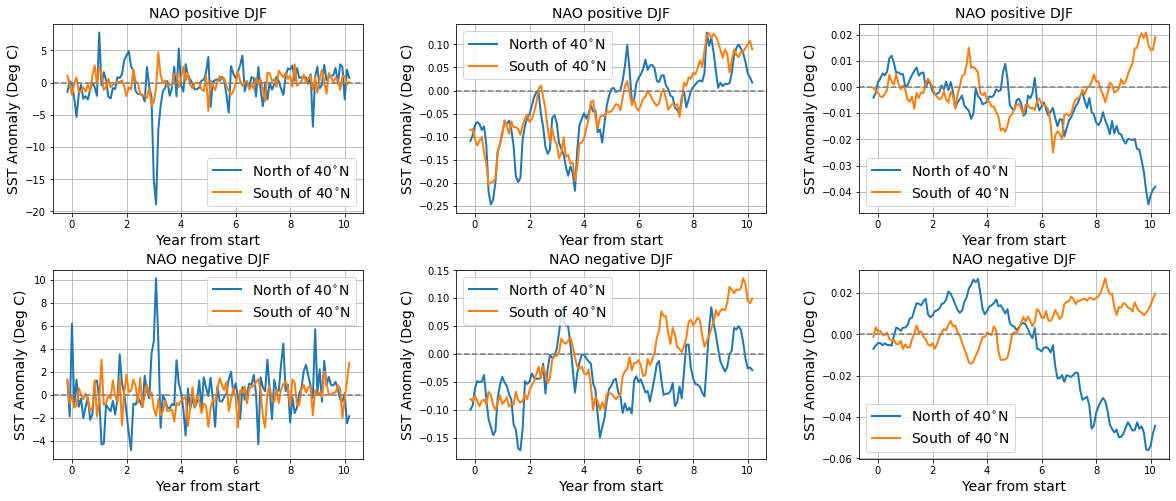

In [9]:
# Plot the timeseries of selected members

grid1 = plt.GridSpec(2, 3, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[20,8])

count_NAOp = xr.where(NAO_season.isel(time=tim_ind) >= NAO_cut, 1, 0)
count_NAOn = xr.where(NAO_season.isel(time=tim_ind) <= -NAO_cut, 1, 0)

Np = count_NAOp.sum().values # 7 days decorrelation time
Nn = count_NAOn.sum().values
ci = 1.96 # coefficiet for large N and 95% confidence interval

for i in range(0,3):
    
    std_err = (ci/np.sqrt(np.ceil(Np)))
    
    ax = fig.add_subplot(grid1[0, i])
    
    var_mean = ds_anom['North_40N'].where(NAO_season.isel(time=tim_ind) >= NAO_cut)
    
    tmp_mean = var_mean.isel(var=i).mean(['start_year', 'r'])
    tmp_std = var_mean.isel(var=i).std(['start_year', 'r'])
    
    ax.plot(np.arange(0-2,len(tmp_mean)-2)/12, tmp_mean, lw=2., label= r'North of $40^{\circ}$N')
    #ax.fill_between(np.arange(0-2,len(tmp_mean)-2)/12, (tmp_mean - std_err*tmp_std), 
    #                (tmp_mean + std_err*tmp_std), alpha=0.3)
    
    var_mean = ds_anom['South_40N'].where(NAO_season.isel(time=tim_ind) >= NAO_cut)
    
    tmp_mean = var_mean.isel(var=i).mean(['start_year', 'r'])
    tmp_std = var_mean.isel(var=i).std(['start_year', 'r'])
    
    ax.plot(np.arange(0-2,len(tmp_mean)-2)/12, tmp_mean, lw=2., label= r'South of $40^{\circ}$N')
    
    ax.axhline(y=0, color='grey', ls='--')
    ax.grid('on')
    ax.legend(fontsize=14)
    ax.set_ylabel('SST Anomaly (Deg C)', fontsize=14)
    ax.set_xlabel('Year from start', fontsize=14)
    ax.set_title('NAO positive DJF', fontsize=14)
    
for i in range(0,3):
    
    std_err = (ci/np.sqrt(np.ceil(Nn)))
    
    ax = fig.add_subplot(grid1[1, i])
    
    var_mean = ds_anom['North_40N'].where(NAO_season.isel(time=tim_ind) <= -NAO_cut)
    
    tmp_mean = var_mean.isel(var=i).mean(['start_year', 'r'])
    tmp_std = var_mean.isel(var=i).std(['start_year', 'r'])
    
    ax.plot(np.arange(0-2,len(tmp_mean)-2)/12, tmp_mean, lw=2., label= r'North of $40^{\circ}$N')
    #ax.fill_between(np.arange(0-2,len(tmp_mean)-2)/12, (tmp_mean - std_err*tmp_std), 
    #                (tmp_mean + std_err*tmp_std), alpha=0.3)
    
    var_mean = ds_anom['South_40N'].where(NAO_season.isel(time=tim_ind) <= -NAO_cut)
    
    tmp_mean = var_mean.isel(var=i).mean(['start_year', 'r'])
    tmp_std = var_mean.isel(var=i).std(['start_year', 'r'])
    
    ax.plot(np.arange(0-2,len(tmp_mean)-2)/12, tmp_mean, lw=2., label= r'South of $40^{\circ}$N')
    
    ax.axhline(y=0, color='grey', ls='--')
    ax.grid('on')
    ax.legend(fontsize=14)
    ax.set_ylabel('SST Anomaly (Deg C)', fontsize=14)
    ax.set_xlabel('Year from start', fontsize=14)
    ax.set_title('NAO negative DJF', fontsize=14)

In [42]:
Np

array(30)